**Описание задания**

Имеется: 

*  набор комментариев, некоторые из которых, содержат описания проектов. 
*  небольшой размеченный набор текстов, в состав которого входит 8 текстов из положительного класса с меткой "1" и 12 текстов из класса - "0"

Задача: создать семантическую поисковую систему, которая сможет из разных наборов текстов извлекать тексты с описанием проектов



**Подход:  zero-shot**

---

Кратко суть подхода - используя значения множественной zero-shot классификации, создать некоторый аналог поискового индекса, который повзволил бы извлекать нужные тексты из набора
В качестве основы будут использоваться mодели SBERT, которые имеют встроенную zero-shot классификацию
А в качестве набора признаков будет использован некий список слов-категорий, близких к категории ПРОЕКТ
например, такой:  
`list_words = ['project', 'proposal', 'job', 'solution', 'research',  'idea', 'algorithm', 'plan', 'initiative', 'announcement']`




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentence_transformers
!pip install flair
!pip install git+https://github.com/pmbaumgartner/setfit
!pip install git+https://github.com/LIAAD/yake
!pip install keybert
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 4.9 MB 34.1 MB/s 
     |████████████████████████████████| 1.3 MB 53.1 MB/s 
     |████████████████████████████████| 120 kB 43.8 MB/s 
     |████████████████████████████████| 6.6 MB 26.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=a502bf2a5ce174f667d98bb0758ff172e14849fcdeda86c0602a8029d43e46fd
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 5.1 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 
     |████████████████████████████████| 981 kB 31.4 MB/s 
     |████████

In [ ]:
# !python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 8.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import torch
import random

import json
from pandas import Series, DataFrame
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import numpy as np
import gzip

from transformers import pipeline
# classifier = pipeline("zero-shot-classification", model="facebook/xglm-564M")
import gensim.downloader
from setfit import SetFitClassifier
from random import choice, randint, shuffle

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

tqdm.pandas()

list_words = ['project', 'proposal', 'job', 'solution', 'research',  'idea', 'algorithm', 'plan', 'initiative', 'announcement']

In [ ]:
import sqlite3 as db
conn = db.connect('/content/drive/MyDrive/WORK/data/labels.db')
train_df = pd.read_sql_query("SELECT text,label FROM labels", conn)
# train_df['label'] = np.array(['', 'project proposal'])[train_df['label'].values]
train_df.sort_values("label", ascending=False).head()

,text,label
0,The suggested EA project / org: work to identi...,1
18,As a concrete program related to the safety of...,1
43,One possible area for exploration is around Sc...,1
40,I propose an infrastructure to generate more a...,1
58,"Hi Vaidehi,What kind of research do you plan o...",1


In [ ]:
index = train_df.sort_values("label", ascending=False).index.to_list()

In [ ]:
dataset = list(zip(train_df.text[index].to_list()[:20], train_df.label[index].to_list()))
shuffle(dataset)
docs = [i[0] for i in dataset] 
labels = [i[1] for i in dataset]

In [ ]:
clf = SetFitClassifier('paraphrase-mpnet-base-v2')
clf.fit(docs, labels) 


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
shuffle(dataset)
docs_eval = [i[0] for i in dataset] 
labels_eval = [i[1] for i in dataset]


In [ ]:
print(labels_eval)
y_pred_eval = clf.predict(docs_eval)
print(y_pred_eval)

[1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
[1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1]


In [ ]:
accuracy_score(labels_eval, y_pred_eval)

1.0

In [ ]:
clf.save('/content/drive/MyDrive/WORK/models/setfit_20.mdl')

In [ ]:
clf_test = SetFitClassifier.load('/content/drive/MyDrive/WORK/models/setfit_20.mdl')

In [ ]:
clf_test.predict(docs_eval)

array([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
import spacy
# nlp = spacy.load("en_core_web_sm")

In [ ]:
# glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
level_1 = glove_vectors.most_similar('project', topn=20)
level_1

[('projects', 0.8065688610076904),
 ('development', 0.6217209696769714),
 ('construction', 0.5998873114585876),
 ('build', 0.5511942505836487),
 ('program', 0.5421556234359741),
 ('plans', 0.5386307835578918),
 ('plan', 0.5361279845237732),
 ('planned', 0.5305522084236145),
 ('renovation', 0.5172025561332703),
 ('initiative', 0.516783595085144),
 ('completed', 0.5117099285125732),
 ('work', 0.5102672576904297),
 ('ambitious', 0.5065388083457947),
 ('funded', 0.5033539533615112),
 ('funding', 0.494592547416687),
 ('completion', 0.49187761545181274),
 ('planning', 0.4888250231742859),
 ('proposed', 0.4873683750629425),
 ('research', 0.4872983396053314),
 ('design', 0.4817836582660675)]

In [ ]:
root_word = 'project'
level_2 = {w[0]: glove_vectors.most_similar(w[0], topn=20) for w in level_1}
level_3 = dict()
set_level_2 = set()
for k, v in level_2.items():
  if k not in level_3:
    level_3[k] = []
  for w in v:
    if glove_vectors.similarity(root_word, w[0]) > 0.3:
      level_3[k].append(w[0])
      set_level_2.add(w[0])

for k, v in level_3.items():
  print(k, len(v))

projects 20
development 17
construction 17
build 17
program 18
plans 15
plan 17
planned 16
renovation 12
initiative 19
completed 13
work 17
ambitious 15
funded 17
funding 17
completion 13
planning 11
proposed 8
research 12
design 10


In [ ]:
print(len(set_level_2))
doc = nlp(' '.join(set_level_2))
set_l_2 = set()
for w in set_level_2:
  for token in nlp(w):
    if token.tag_ in ['VB', 'NN', 'NNS']:
      set_l_2.add(token.lemma_)
list_labels = list(set_level_2)
print(len(set_l_2))

167
88


In [ ]:
l_w = glove_vectors.most_similar('project', topn=20)
l_1 = ['project', 'news'] + [i[0] for i in l_w]
len(l_1), len(set(l_1))
label_coef = {i[0]:i[1] for i in l_w}
label_coef['news'] = glove_vectors.similarity('project', 'news')

In [ ]:
label_coef

{'projects': 0.8065688610076904,
 'development': 0.6217209696769714,
 'construction': 0.5998873114585876,
 'build': 0.5511942505836487,
 'program': 0.5421556234359741,
 'plans': 0.5386307835578918,
 'plan': 0.5361279845237732,
 'planned': 0.5305522084236145,
 'renovation': 0.5172025561332703,
 'initiative': 0.516783595085144,
 'completed': 0.5117099285125732,
 'work': 0.5102672576904297,
 'ambitious': 0.5065388083457947,
 'funded': 0.5033539533615112,
 'funding': 0.494592547416687,
 'completion': 0.49187761545181274,
 'planning': 0.4888250231742859,
 'proposed': 0.4873683750629425,
 'research': 0.4872983396053314,
 'design': 0.4817836582660675,
 'news': 0.16294658}

In [ ]:
root_word = 'project'
label_coef_m = dict()
set_l_1 = set()
for w in l_1:
  for token in nlp(w):
    if token.tag_ in ['VB', 'NN', 'NNS']:
      set_l_1.add(token.lemma_)
      if token.text == root_word:
        continue
      if token.lemma_ in label_coef_m:
        continue
      label_coef_m[token.lemma_] = label_coef[token.text]
list_labels_1 = list(set_l_1)
len(list_labels_1)

14

In [ ]:
label_coef_m

{'news': 0.16294658,
 'project': 0.8065688610076904,
 'development': 0.6217209696769714,
 'construction': 0.5998873114585876,
 'build': 0.5511942505836487,
 'program': 0.5421556234359741,
 'plan': 0.5386307835578918,
 'renovation': 0.5172025561332703,
 'initiative': 0.516783595085144,
 'work': 0.5102672576904297,
 'funding': 0.494592547416687,
 'completion': 0.49187761545181274,
 'research': 0.4872983396053314,
 'design': 0.4817836582660675}

In [ ]:
# from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [ ]:
def calculate_value_labels(r):
  top_label = 'project'
  labels = r['labels']
  scores = r['scores']
  indx = labels.index(top_label)
  if indx:
    if (scores[0] - scores[indx]) > 0.2:
          return 0
  return sum(scores)

def calc_using_coef(r):
  sum = 0
  top_label = 'project'
  labels = r['labels']
  scores = r['scores']
  for num, name in enumerate(labels):
    if name == top_label:
       sum += scores[num]
       rel = scores[num]
       continue
    sum += label_coef_m[name] * scores[num]
  return sum, rel/sum, rel

In [ ]:
classifier('The suggested EA project / org: work to identify important, simple, and uncontroversial ideas as they arise and use social media to get people to pay attention to them.', ['research',  'idea']) #, multi_label=True)

{'sequence': 'The suggested EA project / org: work to identify important, simple, and uncontroversial ideas as they arise and use social media to get people to pay attention to them.',
 'labels': ['idea', 'research'],
 'scores': [0.7449327111244202, 0.25506722927093506]}

In [ ]:
results = []
res_s = []
for index, row in list(train_df.iterrows())[:10]:
  res = classifier(row['text'], list_labels_1, multi_label=True)
  res_s.append(res)
  val = calculate_value_labels(res)
  sss, rel, r_p = calc_using_coef(res)
  results.append((index, val, row['label']))
  print('index=', index, 'val=', val, r_p/val, 'sum_coef=', sss, 'rel=', rel, 'project=', r_p, 'label=', row['label'] )


index= 0 val= 5.446270535700023 0.14691393757310378 sum_coef= 3.2152286318409753 rel= 0.24885727925044246 project= 0.8001330494880676 label= 1
index= 1 val= 7.479547753930092 0.11908104807868858 sum_coef= 4.170614848129502 rel= 0.2135590118306077 project= 0.8906723856925964 label= 0
index= 2 val= 4.8902445925050415 0.18778206162469147 sum_coef= 2.9628599594858973 rel= 0.30993709590949936 project= 0.918300211429596 label= 0
index= 3 val= 5.2701094606891274 0.13796402829607057 sum_coef= 3.0445451758457995 rel= 0.2388158127940781 project= 0.727085530757904 label= 0
index= 4 val= 6.4645152115263045 0.14646929445783813 sum_coef= 3.636164193742058 rel= 0.26039885208533237 project= 0.94685298204422 label= 0
index= 5 val= 7.609414666891098 0.10680170802140529 sum_coef= 4.061007443135431 rel= 0.2001223821544223 project= 0.812698483467102 label= 0
index= 6 val= 6.157619446516037 0.1286235635952501 sum_coef= 3.434288513645493 rel= 0.23061980766245563 project= 0.7920149564743042 label= 0
index= 7 

In [ ]:
res_s[0]

{'sequence': 'The suggested EA project / org: work to identify important, simple, and uncontroversial ideas as they arise and use social media to get people to pay attention to them.',
 'labels': ['work',
  'project',
  'plan',
  'program',
  'research',
  'initiative',
  'design',
  'development',
  'construction',
  'build',
  'renovation',
  'news',
  'funding',
  'completion'],
 'scores': [0.8951610326766968,
  0.8001330494880676,
  0.7185404896736145,
  0.5206565856933594,
  0.49306896328926086,
  0.47426173090934753,
  0.4259122610092163,
  0.3591938614845276,
  0.2263416200876236,
  0.20287057757377625,
  0.1823922097682953,
  0.12008605152368546,
  0.013871738687157631,
  0.013780363835394382]}

In [ ]:
res_s[1]

{'sequence': '4) Between mentors, high-value sponsors, and proposer, they submit some manner of updates on the progress of the project on the forum every Z months.',
 'labels': ['project',
  'work',
  'program',
  'plan',
  'news',
  'development',
  'funding',
  'initiative',
  'design',
  'construction',
  'renovation',
  'build',
  'research',
  'completion'],
 'scores': [0.8906723856925964,
  0.7777547836303711,
  0.7101582288742065,
  0.6805189251899719,
  0.6608580350875854,
  0.6584587693214417,
  0.5815821290016174,
  0.5333424210548401,
  0.46154576539993286,
  0.45102280378341675,
  0.43263256549835205,
  0.3419344127178192,
  0.23566758632659912,
  0.06339894235134125]}

## Load comments

In [ ]:
import re
def split_html_paragraphs(html:str):
    # return [s for s in re.split(r"</?p>|<br/?>", html) if len(s.strip()) > 0]
    return [s for s in re.split(r"<br/?>", html) if len(s.strip()) > 0]



In [ ]:
from pathlib import Path
pref = Path('/content/drive/MyDrive/WORK/data') 

In [ ]:
file_json_gz = Path.joinpath(pref, 'comments.json.gz')

with gzip.open(file_json_gz, 'r') as fin:        
    json_bytes = fin.read()                      

json_str = json_bytes.decode('utf-8')            
comment_dict = json.loads(json_str)                      


comment_dict = [c for c in comment_dict if (c['pageUrl'] is not None) and (c['htmlBody'] is not None)]

for c in comment_dict:
    if "?commentId=" in c['pageUrl']:
        c['commentId'] = c['pageUrl'].split("?commentId=")[1]
    else:
        c['commentId'] = "discussion#" + c['pageUrl'].split("discussion#")[1]

comment_info = DataFrame(comment_dict).set_index("commentId")
comment_info = comment_info[~comment_info.index.duplicated()]
# comment_htmls = Series({c['commentId']: c['htmlBody'] for c in comment_dict})

# comment_texts = comment_info.htmlBody.progress_map(lambda h: BeautifulSoup(h, features="html.parser").get_text())
# comment_texts = comment_texts.map(str.strip)
# comment_texts = comment_texts[comment_texts.map(len) > 50]
# comment_texts.to_csv("./data/comment_texts.csv")

# comment_texts = pd.read_csv("./data/comment_texts.csv").set_index("text").postId
# comment_texts.size

In [ ]:
comment_info_split

NameError: ignored

In [ ]:
h = comment_dict[0]['htmlBody']
BeautifulSoup(h, features="html.parser").get_text().replace('\xa0', ' ')

"You don't have to be smart, or a college graduate. What I'm attempting to do at least for my edification is breaking things down into manageable chunks, so that it can easily be explained. I also enjoy looking at some of the EA numbers and shaking my head.The table is small, but that's because we need people to help us build more extensions to the table. Come get some tools and help me make an addition."

In [ ]:
html_split = comment_info.htmlBody.map(split_html_paragraphs)
comment_htmls_split = pd.concat(
    [comment_info.htmlBody[html_split.map(len) == 1]] + 
    [Series(ts, index=[f'{cid}--{i}' for i in range(len(ts))]) for cid,ts in html_split[html_split.map(len) > 1].items()]
)

In [ ]:
comment_info_split = comment_info.loc[comment_htmls_split.index.map(lambda x: x.split('--')[0])].copy()
comment_info_split.index = comment_htmls_split.index
comment_info_split['htmlBody'] = comment_htmls_split.values
comment_info_split['text'] = comment_info_split.htmlBody.progress_map(lambda h: BeautifulSoup(h, features="html.parser").get_text().replace('\xa0', ' '))

comment_info_split['text'] = comment_info_split['text'].map(lambda x: ' '.join([w for w in x.split() if len(w) < 40])) # Remove non-words
# TODO: there are still some people writing all in bullet-points, so we also need to split lists with long bullet-points, but those are minorities
# Removing these long comments:
# comment_info_split = comment_info_split[(comment_info_split.text.map(len) < 5000) & (comment_info_split.text.map(len) > 70)]
comment_info_split = comment_info_split[comment_info_split.text.map(len) > 70]
comment_info_split.shape

  0%|          | 0/106839 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://climate.envsci.rutgers.edu/robock/talks/NuclearWinter109Lamont.pptx" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://carnegieendowment.org/2018/04/17/new-killer-pathogens-countering-coming-bioweapons-threat-pub-76009" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that doc

(90793, 5)

In [ ]:
text_100 = comment_info_split.text.to_list()[:100]

NameError: ignored

In [ ]:
from transformers import pipeline
# classifier = pipeline("zero-shot-classification", model="facebook/xglm-564M") #vicgalle/xlm-roberta-large-xnli-anli")
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [ ]:
r = classifier(text_100[0], list_labels_1, multi_label=True)

In [ ]:
def calculate_value_labels(r):
  top_label = 'project'
  labels = r['labels']
  scores = r['scores']
  indx = labels.index(top_label)
  if indx:
    if (scores[0] - scores[indx]) > 0.2:
          return 0
  return sum(scores[:10])

calculate_value_labels(r)

0

In [ ]:
t = "The suggested EA project / org: work to identify important, simple, and uncontroversial ideas as they arise and use social media to get people to pay attention to them."
rr = classifier(t, list_labels_1, multi_label=True)
calculate_value_labels(rr)

7.213144481182098

In [ ]:
rr

{'sequence': 'The suggested EA project / org: work to identify important, simple, and uncontroversial ideas as they arise and use social media to get people to pay attention to them.',
 'labels': ['work',
  'effort',
  'part',
  'project',
  'collaboration',
  'plan',
  'develop',
  'venture',
  'feasibility',
  'program',
  'programme',
  'research',
  'initiative',
  'study',
  'design',
  'site',
  'developer',
  'scheme',
  'development',
  'exploration',
  'conservation',
  'launch',
  'infrastructure',
  'construction',
  'experiment',
  'build',
  'creation',
  'renovation',
  'pipeline',
  'phase',
  'restoration',
  'consortium',
  'redevelopment',
  'installation',
  'production',
  'construct',
  'cost',
  'reconstruction',
  'funding',
  'completion'],
 'scores': [0.8951612114906311,
  0.8396821618080139,
  0.8234682083129883,
  0.8001334071159363,
  0.7988818287849426,
  0.718540608882904,
  0.639255940914154,
  0.6301458477973938,
  0.5472177863121033,
  0.520657479763031

In [ ]:
results = []
for num, text in enumerate(text_100[:5]):
  res = classifier(text, list_labels_1, multi_label=True)
  val = calculate_value_labels(res)
  results.append((num, val))
  print('num=', num, 'val=', val)

NameError: ignored

In [ ]:
classifier_fb.task

'zero-shot-classification'

In [ ]:
candidate_labels = ['job', 'project'] #, 'joke']
for s in text_100[:20]:
  print(classifier_fb(s, candidate_labels))
  print(classifier_vic(s, candidate_labels))
  print(100*'-')

{'sequence': "You don't have to be smart, or a college graduate. What I'm attempting to do at least for my edification is breaking things down into manageable chunks, so that it can easily be explained. I also enjoy looking at some of the EA numbers and shaking my head.The table is small, but that's because we need people to help us build more extensions to the table. Come get some tools and help me make an addition.", 'labels': ['project', 'job'], 'scores': [0.8233757019042969, 0.17662426829338074]}
{'sequence': "You don't have to be smart, or a college graduate. What I'm attempting to do at least for my edification is breaking things down into manageable chunks, so that it can easily be explained. I also enjoy looking at some of the EA numbers and shaking my head.The table is small, but that's because we need people to help us build more extensions to the table. Come get some tools and help me make an addition.", 'labels': ['project', 'job'], 'scores': [0.8616064190864563, 0.13839361

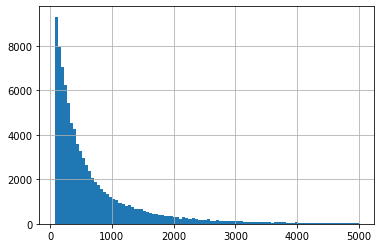

In [ ]:
comment_info_split.text.map(len).hist(bins=100)

In [ ]:
# tpid = comment_info_split.text.map(len)[comment_info_split.text.map(len) < 5000].sort_values().index[-8]
# comment_info_split.loc[tpid].pageUrl

## Classify

In [ ]:
# with open("./data/example_proposals.txt") as f:
#     sents = f.read()
    
# sents = [s for s in sents.split("\n") if len(s) > 0]

In [ ]:
from flair.models import TARSClassifier
from flair.data import Sentence

tars = TARSClassifier.load('tars-base')
# tars1 = TARSClassifier.load("facebook/bart-large-mnli")

2022-08-29 17:24:36,639 loading file /root/.flair/models/tars-base-v8.pt


In [ ]:
sentence = Sentence("great")
classes = ["positive", "negative"]
tars1.predict_zero_shot(sentence, classes)
print(sentence)

Sentence: "great" → positive (0.9691)


In [ ]:
# tars.switch_to_task('AGNews') 
tars.switch_to_task('NEWS_CATEGORY')

In [ ]:
tars.get_current_label_dictionary()

In [ ]:
tars.list_existing_tasks() 

{'AGNews',
 'Amazon',
 'DBPedia',
 'GO_EMOTIONS',
 'IMDB',
 'NEWS_CATEGORY',
 'SST',
 'TREC_6',
 'Yelp'}

In [ ]:
sent1 = Sentence("I absolutely love this !")
sent = Sentence("You don't have to be smart, or a college graduate. What I'm attempting to do at least for my edification is breaking things down into manageable chunks, so that it can easily be explained. I also enjoy looking at some of the EA numbers and shaking my head.The table is small, but that's because we need people to help us build more extensions to the table. Come get some tools and help me make an addition.")
clss = ["job", "project"]
# clss = ["politics", "project"]
tars.predict_zero_shot(sent, clss)
print(sent)
print(100*'_')
tars.predict(sent1)
print(sent1)
tars.switch_to_task("GO_EMOTIONS")
tars.predict(sent1)
print(sent1)


Sentence: "You do n't have to be smart , or a college graduate . What I 'm attempting to do at least for my edification is breaking things down into manageable chunks , so that it can easily be explained . I also enjoy looking at some of the EA numbers and shaking my head.The table is small , but that 's because we need people to help us build more extensions to the table . Come get some tools and help me make an addition ." → project (0.5918)
____________________________________________________________________________________________________
Sentence: "I absolutely love this !" → very_positive_restaurant_sentiment_5 (0.995)
Sentence: "I absolutely love this !" → LOVE (0.9974)


In [ ]:
# tars.switch_to_task('AGNews') 


In [ ]:
def get_class_score(clf, cl_lab, text):
    st = Sentence(text)
    clf.predict_zero_shot(st, [cl_lab], multi_label=False)

    lab = st.get_label()
    tag = lab.value
    score = lab.score if lab.value == cl_lab else 0.0
    return score

In [ ]:
samp_ids = np.random.choice(comment_info_split.index, size=2000, replace=False)
class_probs = comment_info_split.text[samp_ids].progress_map(lambda t: get_class_score(tars, "project proposal", t))
# class_probs.to_pickle("./class_probs.pkl")
# class_probs = pd.read_pickle("./class_probs.pkl")
(class_probs > 0.75).mean()

  0%|          | 0/2000 [00:00<?, ?it/s]

NameError: ignored

## Wrapper for the UI integration

In [ ]:
import sqlite3 as db

Create labeled table:

In [ ]:
def get_target_prob_ids(class_probs:Series, target_prob:float, n_samples:int=10, labeled_ids=None):
    if labeled_ids is None:
        labeled_ids = []
    return (class_probs[class_probs.index.difference(labeled_ids)] - target_prob).abs().sort_values()[:n_samples].index

In [ ]:
# conn = db.connect('./backend/labels.db')
# labeled_ids = pd.read_sql_query("SELECT postId FROM labels", conn).postId.values
labeled_ids = []
closest_ids = get_target_prob_ids(class_probs, target_prob=1.0, n_samples=20, labeled_ids=labeled_ids)

NameError: ignored

In [ ]:
file_classify_csv = Path.joinpath(pref, 'to_classify.csv')

comment_info_split.text[closest_ids].reset_index().to_csv(file_classify_csv, index=True)

In [ ]:
# pd.read_sql_query("SELECT * FROM labels", conn)

In [ ]:
# classes = ["project proposal"]

# for s in sents:
#     st = Sentence(s)
#     tars.predict_zero_shot(st, classes, multi_label=False)
#     print(st)

## Fine-tune

In [ ]:
conn = db.connect('/content/drive/MyDrive/WORK/data/labels.db')
train_df = pd.read_sql_query("SELECT text,label FROM labels", conn)
train_df['label'] = np.array(['', 'project proposal'])[train_df['label'].values]
train_df.to_csv('/content/drive/MyDrive/WORK/data/output/flair_train/train.csv', sep='\t')
train_df.to_csv('/content/drive/MyDrive/WORK/data/output/flair_train/dev.csv', sep='\t')

train_df.sort_values("label", ascending=False).head()

,text,label
0,The suggested EA project / org: work to identi...,project proposal
18,As a concrete program related to the safety of...,project proposal
43,One possible area for exploration is around Sc...,project proposal
40,I propose an infrastructure to generate more a...,project proposal
58,"Hi Vaidehi,What kind of research do you plan o...",project proposal


In [ ]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus

column_name_map = {1: 'text', 2: 'label'}
corpus = CSVClassificationCorpus("./output/flair_train/", column_name_map, label_type="label", skip_header=True, delimiter='\t', no_class_label="")
label_dict = corpus.make_label_dictionary(label_type="label")

2022-07-15 17:15:43,410 Reading data from output/flair_train
2022-07-15 17:15:43,411 Train: output/flair_train/train.csv
2022-07-15 17:15:43,411 Dev: output/flair_train/dev.csv
2022-07-15 17:15:43,412 Test: None
2022-07-15 17:15:43,415 Computing label dictionary. Progress:


3it [00:00, 781.79it/s]

2022-07-15 17:15:43,421 Dictionary created for label 'label' with 2 values: project proposal (seen 3 times)


In [ ]:
tars.add_and_switch_to_new_task("jobs", label_dictionary=label_dict, label_type="label")

In [ ]:
from flair.models import TARSClassifier
from flair.trainers import ModelTrainer

trainer = ModelTrainer(tars, corpus)

trainer.train(base_path='./output/flair_train/artifacts/', # path to store the model artifacts
              learning_rate=0.02, # use very small learning rate
              mini_batch_size=16,
              mini_batch_chunk_size=4, # optionally set this if transformer is too much for your machine
              max_epochs=10, # terminate after 10 epochs
              )

2022-07-15 17:15:47,269 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:47,272 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (decoder): Linear(in_features=768, out_features=2, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (locked_dropout): LockedDropout(p=0.0)
    (word_dropout): WordDropout(p=0.0)
    (loss_function): CrossEntropyLoss()
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttentio

/home/vpetukhov/local/miniconda3/envs/interactive_classification/lib/python3.8/site-packages/flair/trainers/trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-07-15 17:15:48,503 epoch 1 - iter 1/1 - loss 0.05037894 - samples/sec: 13.77 - lr: 0.020000
2022-07-15 17:15:48,505 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:48,506 EPOCH 1 done: loss 0.0504 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]

2022-07-15 17:15:48,846 Evaluating as a multi-label problem: False
2022-07-15 17:15:48,858 DEV : loss 0.003526731627061963 - f1-score (micro avg)  1.0
2022-07-15 17:15:48,864 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:48,865 saving best model


2022-07-15 17:15:49,454 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:50,608 epoch 2 - iter 1/1 - loss 0.00097065 - samples/sec: 14.40 - lr: 0.020000
2022-07-15 17:15:50,611 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:50,612 EPOCH 2 done: loss 0.0010 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]

2022-07-15 17:15:50,961 Evaluating as a multi-label problem: False
2022-07-15 17:15:50,972 DEV : loss 0.002646335167810321 - f1-score (micro avg)  1.0
2022-07-15 17:15:50,978 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:50,979 ----------------------------------------------------------------------------------------------------


2022-07-15 17:15:52,077 epoch 3 - iter 1/1 - loss 0.00172945 - samples/sec: 15.16 - lr: 0.020000
2022-07-15 17:15:52,080 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:52,081 EPOCH 3 done: loss 0.0017 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

2022-07-15 17:15:52,403 Evaluating as a multi-label problem: False
2022-07-15 17:15:52,417 DEV : loss 0.001737547921948135 - f1-score (micro avg)  1.0
2022-07-15 17:15:52,423 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:52,424 ----------------------------------------------------------------------------------------------------


2022-07-15 17:15:53,770 epoch 4 - iter 1/1 - loss 0.00105890 - samples/sec: 12.40 - lr: 0.020000
2022-07-15 17:15:53,774 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:53,775 EPOCH 4 done: loss 0.0011 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]

2022-07-15 17:15:54,139 Evaluating as a multi-label problem: False
2022-07-15 17:15:54,152 DEV : loss 0.0013952214503660798 - f1-score (micro avg)  1.0
2022-07-15 17:15:54,159 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:54,162 ----------------------------------------------------------------------------------------------------


2022-07-15 17:15:55,468 epoch 5 - iter 1/1 - loss 0.00073950 - samples/sec: 12.70 - lr: 0.020000
2022-07-15 17:15:55,470 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:55,471 EPOCH 5 done: loss 0.0007 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]

2022-07-15 17:15:55,851 Evaluating as a multi-label problem: False
2022-07-15 17:15:55,864 DEV : loss 0.0011605862528085709 - f1-score (micro avg)  1.0
2022-07-15 17:15:55,870 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:55,871 ----------------------------------------------------------------------------------------------------


2022-07-15 17:15:57,200 epoch 6 - iter 1/1 - loss 0.00051253 - samples/sec: 12.46 - lr: 0.020000
2022-07-15 17:15:57,202 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:57,202 EPOCH 6 done: loss 0.0005 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]

2022-07-15 17:15:57,522 Evaluating as a multi-label problem: False
2022-07-15 17:15:57,535 DEV : loss 0.001008349470794201 - f1-score (micro avg)  1.0
2022-07-15 17:15:57,542 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:57,543 ----------------------------------------------------------------------------------------------------


2022-07-15 17:15:58,687 epoch 7 - iter 1/1 - loss 0.00072862 - samples/sec: 14.51 - lr: 0.020000
2022-07-15 17:15:58,690 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:58,691 EPOCH 7 done: loss 0.0007 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]

2022-07-15 17:15:59,045 Evaluating as a multi-label problem: False
2022-07-15 17:15:59,057 DEV : loss 0.0008032931946218014 - f1-score (micro avg)  1.0
2022-07-15 17:15:59,063 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:59,064 ----------------------------------------------------------------------------------------------------


2022-07-15 17:16:00,313 epoch 8 - iter 1/1 - loss 0.00054428 - samples/sec: 13.27 - lr: 0.020000
2022-07-15 17:16:00,316 ----------------------------------------------------------------------------------------------------
2022-07-15 17:16:00,317 EPOCH 8 done: loss 0.0005 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]

2022-07-15 17:16:00,689 Evaluating as a multi-label problem: False
2022-07-15 17:16:00,702 DEV : loss 0.0007176553481258452 - f1-score (micro avg)  1.0
2022-07-15 17:16:00,708 BAD EPOCHS (no improvement): 0
2022-07-15 17:16:00,710 ----------------------------------------------------------------------------------------------------


2022-07-15 17:16:02,168 epoch 9 - iter 1/1 - loss 0.00045894 - samples/sec: 11.31 - lr: 0.020000
2022-07-15 17:16:02,172 ----------------------------------------------------------------------------------------------------
2022-07-15 17:16:02,173 EPOCH 9 done: loss 0.0005 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]

2022-07-15 17:16:02,596 Evaluating as a multi-label problem: False
2022-07-15 17:16:02,610 DEV : loss 0.0006246347329579294 - f1-score (micro avg)  1.0
2022-07-15 17:16:02,617 BAD EPOCHS (no improvement): 0
2022-07-15 17:16:02,619 ----------------------------------------------------------------------------------------------------


2022-07-15 17:16:04,042 epoch 10 - iter 1/1 - loss 0.00029327 - samples/sec: 11.68 - lr: 0.020000
2022-07-15 17:16:04,044 ----------------------------------------------------------------------------------------------------
2022-07-15 17:16:04,046 EPOCH 10 done: loss 0.0003 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]

2022-07-15 17:16:04,424 Evaluating as a multi-label problem: False
2022-07-15 17:16:04,437 DEV : loss 0.0005788668640889227 - f1-score (micro avg)  1.0
2022-07-15 17:16:04,445 BAD EPOCHS (no improvement): 0


2022-07-15 17:16:05,211 Test data not provided setting final score to 0


{'test_score': 0,
 'dev_score_history': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'train_loss_history': [0.05037894348303477,
  0.0009706520165006319,
  0.0017294536034266155,
  0.0010589007288217545,
  0.0007394989176342884,
  0.0005125256332879266,
  0.0007286227773874998,
  0.0005442828017597398,
  0.0004589410576348503,
  0.0002932692295871675],
 'dev_loss_history': [0.003526731627061963,
  0.002646335167810321,
  0.001737547921948135,
  0.0013952214503660798,
  0.0011605862528085709,
  0.001008349470794201,
  0.0008032931946218014,
  0.0007176553481258452,
  0.0006246347329579294,
  0.0005788668640889227]}

In [ ]:
samp_ids = np.random.choice(comment_info_split.index, size=2000, replace=False)
class_probs = comment_info_split.text[samp_ids].progress_map(lambda t: get_class_score(tars, "project proposal", t))
(class_probs > 0.75).mean()

  0%|          | 0/2000 [00:00<?, ?it/s]

0.167

In [ ]:
labeled_ids = pd.read_sql_query("SELECT postId FROM labels", conn).postId.values
closest_ids = get_target_prob_ids(class_probs, target_prob=1.0, n_samples=50, labeled_ids=labeled_ids)

- Can use Colab as a training set
- Can contribute GraphQL documentation as our result

In [ ]:
comment_info_split.text[closest_ids].reset_index().to_csv("./data/to_classify.csv", index=True)